## Recover Result Utils

In [1]:
"""Utils to load results"""
import os
import pickle

def build_dir_path(missing_type, simulation, graph):
    path = "./"
    if missing_type == "100n":
        path += "missing_output_100_nodes_inf/"
    elif missing_type == "30p":
        path += "missing_output_simulations_30_p_infected/"
    else:
        raise ValueError("No such missing type")

    if simulation in ["si", "sis", "sir"]:
        path += simulation
        path += "/"
    else:
        raise ValueError("No such simulation")
    
    if graph in ["scale_free_100", "scale_free_1000", "synthetic_internet_100", "synthetic_internet_1000", "us_power_grid", "internet"]:
        path += graph
        path += "/"
    return path

def load_results(missing_type, simulation, graph):
    path = build_dir_path(missing_type, simulation, graph)
    
    results_path = os.popen(f"find {path} -name 'results*'").read().replace("\n", "")
    with open(results_path, "rb") as f:
        results = pickle.load(f)
    return results

def load_main_ref_graph(missing_type, simulation, graph):
    path = build_dir_path(missing_type, simulation, graph)
    
    results_path = os.popen(f"find {path} -name 'main_ref_graph*'").read().replace("\n", "")
    with open(results_path, "rb") as f:
        results = pickle.load(f)
    return results

In [2]:
import rumor_centrality.rumor_detection as raw
import rumor_centrality.jordan_center_alternative as jo

metrics = {
    "rumor_centrality" : lambda g: raw.get_center_prediction(
        raw.networkx_graph_to_adj_list(g), use_fact=False
    ),
    "jordan_centrality": jo.centers_by_jordan_center,
    "betweenness_centrality": jo.centers_by_betweenness_centrality,
    "distance_centrality": jo.centers_by_distance_centrality,
}

In [3]:
"""Utils to reconstruct normalized hop distances"""
import networkx as nx
from tqdm import tqdm

def reconstruct_hop_distances(main_ref_graph, results):
    shortest_paths = nx.shortest_path(main_ref_graph)
    def get_best_hop_distance(g, original_centers, predicted_centers):
        best_pair = None
        best_distance = len(g.nodes)
        for o_c in original_centers:
            for p_c in predicted_centers:
                d = len(shortest_paths[o_c][p_c])
                if d < best_distance:
                    best_distance = d
                    best_pair = (o_c, p_c)
        return best_pair, best_distance
    def get_all_hop_distances(g, original_centers, predicted_centers):
        distances = []
        for o_c in original_centers:
            for p_c in predicted_centers:
                distances.append(len(shortest_paths[o_c][p_c]))
        return distances
    
    import statistics
    def get_avg_hop_distance(g, original_centers, predicted_centers):
        return statistics.mean(get_all_hop_distances(g, original_centers, predicted_centers))
    def get_median_hop_distance(g, original_centers, predicted_centers):
        return statistics.median(get_all_hop_distances(g, original_centers, predicted_centers))

    center_results = {}
    for k, v in results.items():
        predicted_centers = []
        for _r in v:
            if _r is None:
                predicted_centers.append((None, None))
            else:
                predicted_centers.append((_r["predicted_centers"], _r["real_centers"]))
        center_results[k] = predicted_centers
    
    def normalize_hop_distances(hop_distances):
        normalized = {}
        for percent_missing, hop_distance_freq in hop_distances.items():
            total_valid = sum(hop_distance_freq.values()) - hop_distance_freq.get(-1, 0)

            normalized_hop_distance_freq = {}
            for hop_distance, freq in hop_distance_freq.items():
                if hop_distance == -1:
                    continue
                normalized_hop_distance_freq[hop_distance] = round(freq / total_valid * sum(hop_distance_freq.values()))
            normalized[percent_missing] = normalized_hop_distance_freq
        return normalized
    
    reference_map = []

    # Map results to hop distances
    hop_distance_freq_by_p_r_by_metric = {}

    for metric_name in metrics.keys():
        hop_distance_freq_by_p_r = {}
        for p_r, values in center_results.items():
            hop_distance_freq = {}
            for i, centers in enumerate(values):
                predicted_centers = centers[0]
                real_centers = centers[1]
                if predicted_centers is None or real_centers is None:
                    hop_distance_freq[-1] = hop_distance_freq.get(-1, 0) + 1
                    reference_map.append((p_r, i, -1))
                else:
                    predicted_centers = predicted_centers[metric_name]
                    
                    # best_pair, best_distance = get_best_hop_distance(main_ref_graph, real_centers, predicted_centers)
                    avg_hop_distance = get_median_hop_distance(main_ref_graph, real_centers, predicted_centers)
                    hop_distance_freq[avg_hop_distance] = hop_distance_freq.get(avg_hop_distance, 0) + 1

                    reference_map.append((p_r, i, avg_hop_distance))

            hop_distance_freq_by_p_r[p_r] = hop_distance_freq
        hop_distance_freq_by_p_r_by_metric[metric_name] = normalize_hop_distances(hop_distance_freq_by_p_r)
    return hop_distance_freq_by_p_r_by_metric

In [4]:
def get_normalized_hop_distances(missing_type, simulation, graph):
    r = load_results(missing_type, simulation, graph)
    main_ref_graph = load_main_ref_graph(missing_type, simulation, graph)
    return reconstruct_hop_distances(main_ref_graph, r)

In [5]:
def get_prediction_count(missing_type, simulation, graph):
    r = load_results(missing_type, simulation, graph)
    
    prediction_counts = {}
    for percent_missing, data in r.items():
        prediction_counts[percent_missing] = {}
        for sample in data:
            if sample is None:
                continue
            for metric, predictions in sample["predicted_centers"].items():
                prediction_counts[percent_missing][metric] = prediction_counts[percent_missing].get(
                    metric, []
                ) + [len(predictions)]
    
    avg_prediction_counts = {}

    for p in prediction_counts.keys():
        avg_prediction_counts[p] = {}
        for metric in prediction_counts[p]:
            max_pred = max(prediction_counts[p][metric])
            min_pred = min(prediction_counts[p][metric])
            avg = sum(prediction_counts[p][metric]) / len(prediction_counts[p][metric])
            
            avg_prediction_counts[p][metric] = (min_pred, avg, max_pred)

    return avg_prediction_counts

## Analytical Utils

In [6]:
def get_avg_hop_distances(normalized_hop_distances):
    avgs_hop_distances = {}
    for metric, percent_missing in normalized_hop_distances.items():
        p_lookup = {}
        for p, hop_distances in percent_missing.items():
            avg = sum(list(map(lambda x: x[0] * x[1], hop_distances.items()))) / sum(hop_distances.values())
            p_lookup[p] = avg

        avgs_hop_distances[metric] = p_lookup
    return avgs_hop_distances

## Analyses

In [7]:
from tqdm import tqdm
import pickle
filename = "median_normalized_missing_results.pickle"
if os.path.exists(filename):
    with open(filename, "rb") as f:
        results = pickle.load(f)
else:
    results = {}
    
    with tqdm(total=2*3*5) as progress_bar:
        for t in ["100n", "30p"]:
            for sim in ["si", "sir", "sis"]:
                for g in ["synthetic_internet_100", "synthetic_internet_1000", "scale_free_100", "scale_free_1000", "us_power_grid"]:
                    r = get_normalized_hop_distances(t, sim, g)
                    results[(t, sim, g)] = r
                    progress_bar.update(1)
    
    with open(filename, "wb") as f:
        pickle.dump(results, f)

In [8]:
import pickle
filename = "median_diameter_normalized_missing_results.pickle"
if os.path.exists(filename):
    with open(filename, "rb") as f:
        diameter_normalized_results = pickle.load(f)
else:
    # Diameter Normalization
    diameter_normalized_results = {}
    for config, metric_hop_distances in results.items():
        diameter_normalized_results[config] = {}

        # first two parameters should be irrelevant
        main_ref_graph = load_main_ref_graph("30p", "si", config[2])
        diameter = nx.diameter(main_ref_graph)
        for metric_name, missing_precent_lookup in metric_hop_distances.items():
            new_missing_precent_lookup = {}
            for missing_percent, hop_distance_lookup in missing_precent_lookup.items():
                new_hop_distance_lookup = dict([
                    (hop_distance / diameter, freq)
                    for hop_distance, freq in hop_distance_lookup.items()
                ])
                new_missing_precent_lookup[missing_percent] = new_hop_distance_lookup

            diameter_normalized_results[config][metric_name] = new_missing_precent_lookup
    with open(filename, "wb") as f:
        pickle.dump(diameter_normalized_results, f)

In [9]:
with open("best_normalized_missing_results.pickle", "rb") as f:
    best = pickle.load(f)

with open("mean_normalized_missing_results.pickle", "rb") as f:
    mean = pickle.load(f)

with open("median_normalized_missing_results.pickle", "rb") as f:
    median = pickle.load(f)

with open("best_diameter_normalized_missing_results.pickle", "rb") as f:
    best_normed = pickle.load(f)

with open("mean_diameter_normalized_missing_results.pickle", "rb") as f:
    mean_normed = pickle.load(f)

with open("median_diameter_normalized_missing_results.pickle", "rb") as f:
    median_normed = pickle.load(f)



In [10]:
name_mapping = {
    "scale_free_1000": "Scale Free (1000)",
    "synthetic_internet_1000": "Synthetic Internet (1000)",
    "us_power_grid": "US Power Grid",
}

In [11]:
metrics.keys()

dict_keys(['rumor_centrality', 'jordan_centrality', 'betweenness_centrality', 'distance_centrality'])

In [12]:
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comparative_graph(r):
    interested_results = [
        (config, r)
        for config, r in r.items()
        if (
            config[0] == "30p"
            and config[1] == "si"
            and ("100" not in config[2] or "1000" in config[2])
        )
    ]

    fig, axes = plt.subplots(1, len(interested_results), figsize=(15,5), sharey=True)

    for i, (config, result) in tqdm(enumerate(interested_results)):
        ax = axes[i]
        df = DataFrame(get_avg_hop_distances(result))
        df.plot(title=str(config), ax=ax, legend=False)

        colors = dict([(l.get_label(), l.get_color()) for l in ax.lines])

        for col in df.columns:
            l = sns.regplot(x=df.index, y=df[col], ax=ax, scatter=False, label=f"{col}-reg", color=colors[col],
                           # fit_ref=False,
                            ci=None,
                           )

        for line in ax.lines:
            line.set_label(" ".join([s.capitalize() for s in line.get_label().split("_")]))
            if "reg" in line.get_label():
                line.set_linestyle(":")
        ax.set_title(name_mapping[config[2]])

        ax.set_xlabel("Missing percent")
        ax.set_ylabel("Diameter Norm. Hop Distance")

        ax.set_ylim([0,1])

    ax.legend(ncol=2, bbox_to_anchor=[0, -0.2]) 


3it [00:00, 45.02it/s]


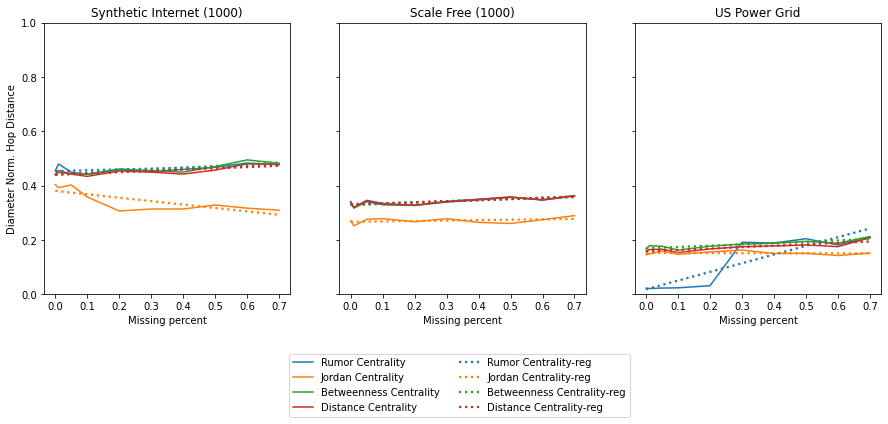

In [13]:
plot_comparative_graph(best_normed)

3it [00:00, 59.14it/s]


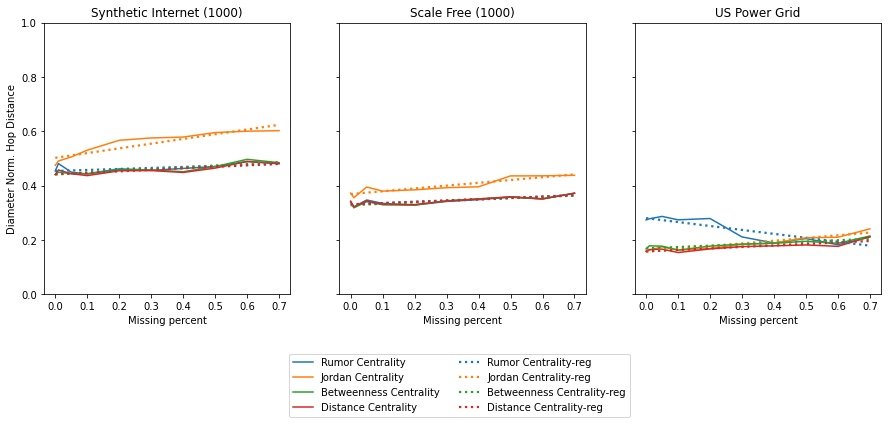

In [14]:
plot_comparative_graph(mean_normed)

In [15]:
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

def plot_all_reg_graphs(r):
    interested_results = [
        (config, r)
        for config, r in r.items()
        if config[0] != "100n" and ("100" not in config[2] or "1000" in config[2])
    ]

    for config, result in tqdm(interested_results):
        if "100n" in config:
            continue
        if "100" in config[2] and "1000" not in config[2]:
            continue

        df = DataFrame(get_avg_hop_distances(result))
        fig, ax = plt.subplots(1,1, figsize=(7,5))
        df.plot(title=str(config), ax=ax)

        colors = dict([(l.get_label(), l.get_color()) for l in ax.lines])

        for col in df.columns:
            l = sns.regplot(x=df.index, y=df[col], ax=ax, scatter=False, label=f"{col}-reg", color=colors[col])

        for line in ax.lines:
            if "reg" in line.get_label():
                line.set_linestyle(":")
        ax.set_title(config)

        ax.set_xlabel("Missing percent")
        ax.set_ylabel("Diameter Norm. Hop Distance")

        ax.legend(ncol=2, bbox_to_anchor=[0.95, -0.15])

        fig

Except for jordan centrality the metrics behave pretty similar, rumor centrality being a bit better. Lets plot rumor centraltiy and jordan centrality next to each other for various graphs.

In [16]:
def plot_metric(results, metric_name, config_filter=lambda config: True, ax=None, legend=False):
    metric_results = {}

    for k, v in results.items():
        metric_results[k] = v[metric_name]

    df = DataFrame(index=metric_results[k].keys())
    for config, result in metric_results.items():
        if config_filter(config) is False:
            continue
        avg = get_avg_hop_distances({"a": result})["a"]
        df[config] = avg.values()
    df.plot(ax=ax, title=metric_name, legend=legend)

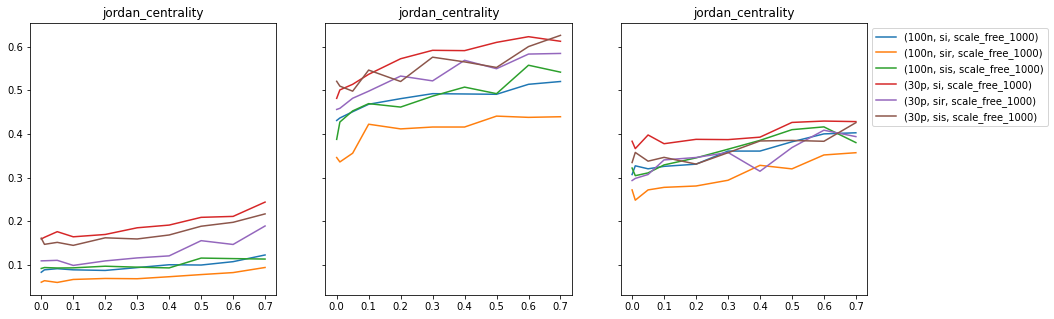

In [17]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)
plot_metric(diameter_normalized_results, "jordan_centrality", lambda x: x[2] == "us_power_grid", ax=axes[0])
plot_metric(diameter_normalized_results, "jordan_centrality", lambda x: x[2] == "synthetic_internet_1000", ax=axes[1])
plot_metric(diameter_normalized_results, "jordan_centrality", lambda x: x[2] == "scale_free_1000", ax=axes[2])

axes[2].legend(bbox_to_anchor=(1, 1))

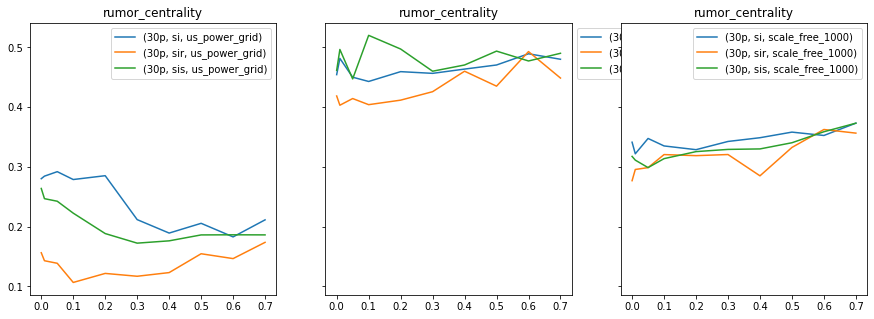

In [18]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)
plot_metric(diameter_normalized_results, "rumor_centrality", lambda x: x[0] == "30p" and x[2] == "us_power_grid", ax=axes[0])
plot_metric(diameter_normalized_results, "rumor_centrality", lambda x: x[0] == "30p" and x[2] == "synthetic_internet_1000", ax=axes[1])
plot_metric(diameter_normalized_results, "rumor_centrality", lambda x: x[0] == "30p" and x[2] == "scale_free_1000", ax=axes[2])

axes[0].legend(bbox_to_anchor=(1, 1))
axes[1].legend(bbox_to_anchor=(1, 1))
axes[2].legend(bbox_to_anchor=(1, 1))

In [19]:
import seaborn as sns

# Barplot, x: Missing, y: avg. hop distance, plot all graphs for one metric and one simulation type
def metric_graph_compare(results, metric_name, simulation, missing_type, ax=None, legend=False):
    metric_results = {}

    for k, v in results.items():
        metric_results[k] = v[metric_name]

    df = DataFrame(index=metric_results[k].keys())
    for config, result in metric_results.items():
        if simulation not in config or missing_type not in config:
            continue
        avg = get_avg_hop_distances({"a": result})["a"]
        df[config[2]] = avg.values()
    return df

def plot_rumor_against_jordan(results, simulation, missing_type):
    fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=True)
    df = metric_graph_compare(results, "rumor_centrality", simulation, missing_type, ax=axes[0], legend=True)
    df.plot.bar(ax=axes[0])
    for col in df.columns:
        sns.regplot(x=list(range(len(df[col]))), y=df[col], ax=axes[0], scatter=False)
    axes[0].set_title("Rumor Centrality")
    axes[0].set_xlabel("Missing Percent")
    axes[0].set_ylabel("Avg. Hop Distance")


    df = metric_graph_compare(results, "jordan_centrality", simulation, missing_type, ax=axes[1], legend=False)
    df.plot.bar(ax=axes[1])
    for col in df.columns:
        sns.regplot(x=list(range(len(df[col]))), y=df[col], ax=axes[1], scatter=False)
    axes[1].set_title("Jordan Centrality")
    axes[1].set_xlabel("Missing Percent")
    axes[1].set_ylabel("Avg. Hop Distance")
    fig.show()

/tmp/ipykernel_7807/2052612487.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


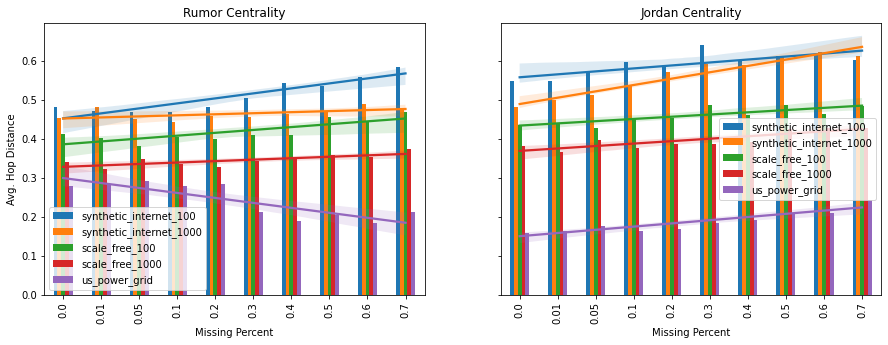

In [20]:
plot_rumor_against_jordan(diameter_normalized_results, "si", "30p")

# Rumor vs Jordan - 30p - Various simulations

/tmp/ipykernel_7807/2052612487.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


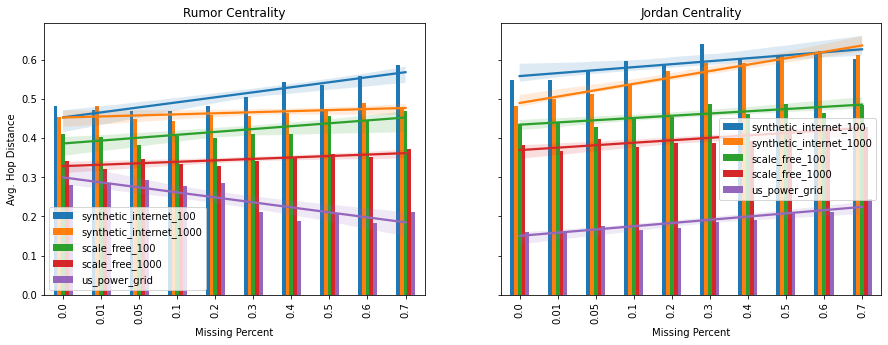

In [21]:
plot_rumor_against_jordan(diameter_normalized_results, "si", "30p")

/tmp/ipykernel_7807/2052612487.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


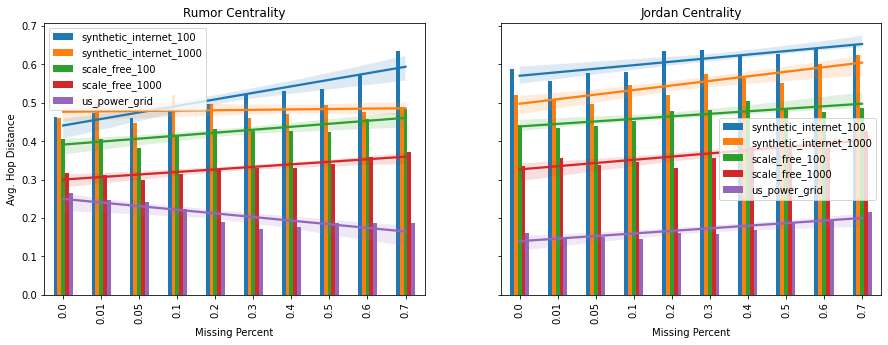

In [22]:
plot_rumor_against_jordan(diameter_normalized_results, "sis", "30p")

/tmp/ipykernel_7807/2052612487.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


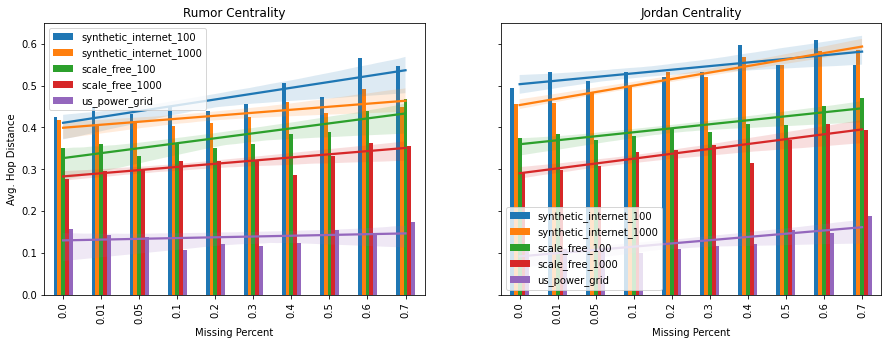

In [23]:
plot_rumor_against_jordan(diameter_normalized_results, "sir", "30p")

In [24]:
r = load_results("30p", "si", "us_power_grid")

In [25]:
from rumor_centrality.graph_visualization import plot_nx_graph
import networkx as nx

In [26]:
diameters_over_p = {}
avg_degree_over_p = {}
for p in tqdm([0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]):
    diameters_over_p[p] = nx.diameter(r[p][0]["ex_graph"])
    avg_degree_over_p[p] = len(r[p][0]["ex_graph"].edges) / len(r[p][0]["ex_graph"].nodes)

100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.01s/it]


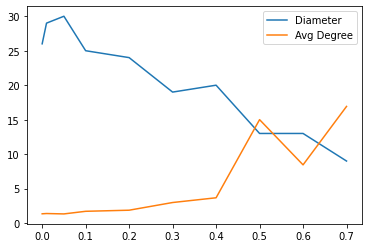

In [27]:
plt.plot(diameters_over_p.keys(), diameters_over_p.values(), label="Diameter")
plt.plot(avg_degree_over_p.keys(), avg_degree_over_p.values(), label="Avg Degree")
plt.legend()

In [28]:
"""
["100n", "30p"]:
["si", "sir", "sis"]:
["synthetic_internet_100", "synthetic_internet_1000", "scale_free_100", "scale_free_1000", "us_power_grid"]:                    
"""

'\n["100n", "30p"]:\n["si", "sir", "sis"]:\n["synthetic_internet_100", "synthetic_internet_1000", "scale_free_100", "scale_free_1000", "us_power_grid"]:                    \n'

In [29]:
config_filter = lambda x: (
    x[0] == "30p"

    and x[1] == "si"
    and ("100" in x[2] and "1000" in x[2] or "100" not in x[2])
)

In [30]:
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

def get_averaged_df(r, config_filter):
    interested_results = [
        (config, r)
        for config, r in r.items()
        if config_filter(config)
    ]

    
    dfs = []
    for i, (config, result) in tqdm(enumerate(interested_results)):
        df = DataFrame(get_avg_hop_distances(result))
        df.style.set_caption(str(config))
        
        dfs.append((df, config))
    return dfs


In [31]:
def get_max_change_table(r):
    dfs = get_averaged_df(r,  config_filter)

    maximum_change_over_missing = DataFrame(
        columns=['distance_centrality', 'betweenness_centrality', 'jordan_centrality', 'rumor_centrality'],
        index=["scale_free_1000", "synthetic_internet_1000", "us_power_grid"],
    )

    for df, config in dfs:
        graph = config[2]
        for col in df.columns:
            base = df[col][0]
            df[col] = abs(df[col] - base)
            m = max(df[col])
            percent_missing = df.loc[df[col] == m].index[0]
            maximum_change_over_missing[col][graph] = (round(m, 3), percent_missing)

    return maximum_change_over_missing.transpose()

In [32]:
def get_all_change_table(r, metric):
    dfs = get_averaged_df(r, config_filter)

    percent_missing = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    all_change_over_missing = DataFrame(
        columns=["scale_free_1000", "synthetic_internet_1000", "us_power_grid"],
        index=percent_missing,
    )

    for df, config in dfs:
        graph = config[2]
        series = df[metric]
        base = series[0.0]
        series = round(abs(series - base), 3)
        # print(series)
        all_change_over_missing[graph] = series
        
        #all_change_over_missing[graph] = [round(v, 3) for v in df[col]]
    
    all_change_over_missing = all_change_over_missing.rename(columns=dict([(g, name_mapping[g]) for g in name_mapping]))
    return all_change_over_missing

In [33]:
get_all_change_table(mean_normed, "jordan_centrality")

3it [00:00, 67.47it/s]


,Scale Free (1000),Synthetic Internet (1000),US Power Grid
0.00,0.000,0.000,0.000
0.01,0.017,0.016,0.004
0.05,0.022,0.031,0.017
0.10,0.007,0.056,0.005
0.20,0.012,0.092,0.011
0.30,0.020,0.101,0.026
0.40,0.023,0.104,0.031
0.50,0.063,0.121,0.050
0.60,0.064,0.126,0.052
0.70,0.066,0.128,0.083


In [34]:
get_max_change_table(mean_normed)

3it [00:00, 931.24it/s]


,scale_free_1000,synthetic_internet_1000,us_power_grid
distance_centrality,"(0.029, 0.7)","(0.048, 0.6)","(0.054, 0.7)"
betweenness_centrality,"(0.034, 0.7)","(0.056, 0.6)","(0.047, 0.7)"
jordan_centrality,"(0.066, 0.7)","(0.128, 0.7)","(0.083, 0.7)"
rumor_centrality,"(0.031, 0.7)","(0.035, 0.6)","(0.091, 0.6)"


In [35]:
get_max_change_table(best_normed)

3it [00:00, 1640.75it/s]


,scale_free_1000,synthetic_internet_1000,us_power_grid
distance_centrality,"(0.021, 0.01)","(0.041, 0.6)","(0.049, 0.7)"
betweenness_centrality,"(0.026, 0.7)","(0.054, 0.6)","(0.046, 0.7)"
jordan_centrality,"(0.019, 0.01)","(0.097, 0.2)","(0.017, 0.3)"
rumor_centrality,"(0.022, 0.7)","(0.029, 0.6)","(0.187, 0.7)"


In [36]:
def latex_print_max_change_table(table):
    x = table.transpose()
    for col in x.columns:
        s = col + " "
        for y in x[col]:
            change, missing_percent = y
            s += f"&{change} ({missing_percent})\t"
        s += r"\\"
        print(s)

In [37]:
latex_print_max_change_table(get_max_change_table(best_normed))

3it [00:00, 2095.75it/s]

distance_centrality &0.021 (0.01)	&0.041 (0.6)	&0.049 (0.7)	\\
betweenness_centrality &0.026 (0.7)	&0.054 (0.6)	&0.046 (0.7)	\\
jordan_centrality &0.019 (0.01)	&0.097 (0.2)	&0.017 (0.3)	\\
rumor_centrality &0.022 (0.7)	&0.029 (0.6)	&0.187 (0.7)	\\


In [38]:
def get_prediction_count_table(metric):
    graphs = ["scale_free_1000", "synthetic_internet_1000", "us_power_grid"]
    percent_missing = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    
    df = DataFrame(columns=graphs, index=percent_missing)
    
    for g in graphs:
        experiment_data = get_prediction_count("30p", "si", g)
        for percent_removed, prediction_count in experiment_data.items():
            min_pred, avg_pred, max_pred = prediction_count[metric]
            df[g][percent_removed] = avg_pred
    
    
    df = df.rename(columns=dict([(g, name_mapping[g]) for g in graphs]))
    return df

In [39]:
jordan_cent_predictions_df = get_prediction_count_table("jordan_centrality")
rumor_cent_predictions_df = get_prediction_count_table("rumor_centrality")

In [41]:
plt.rcParams["figure.dpi"] = 1024


fig, axes = plt.subplots(1,2, figsize=(10, 5))
jordan_cent_predictions_df.plot(
    legend=True,
    title="Jordan Centrality",
    xlabel="Missing Nodes (%)",
    ylabel="Number of Predicted Centers",
    ax=axes[0],
)


colors = dict([(l.get_label(), l.get_color()) for l in axes[0].lines])

all_changes = get_all_change_table(mean_normed, "jordan_centrality")
all_changes.plot(
    ax=axes[0],
    secondary_y=True,
    linestyle=":",
    color=[colors.get(x, '#333333') for x in all_changes.columns]
)


plt.rcParams["figure.dpi"] = 1024
rumor_cent_predictions_df.plot(
    legend=True,
    title="Rumor Centrality",
    logy=False,
    xlabel="Missing Nodes (%)",
    ylabel="Number of Predicted Centers",
    ax=axes[1],
)
fig.tight_layout()

3it [00:00, 1518.94it/s]


In [ ]:
def get_distances(graph, sample_nr, metric):
    r = load_results("30p", "si", graph)
    main_ref_graph = load_main_ref_graph("30p", "si", graph)
    sp = dict(nx.all_pairs_shortest_path(main_ref_graph))

    distances = {}
    for percent_missing in r:
        sample = r[percent_missing][sample_nr]
        real = sample["real_centers"][0]
        predicted_distances = {}
        for predicted in sample["predicted_centers"][metric]:
            distance = len(sp[real][predicted]) - 1
            predicted_distances[distance] = predicted_distances.get(distance, 0) + 1

        distances[percent_missing] = predicted_distances
    return distances
    

In [ ]:
get_distances("us_power_grid", 1, "jordan_centrality")

In [ ]:
get_distances("synthetic_internet_1000", 1, "jordan_centrality")

In [ ]:
get_distances("scale_free_1000", 1, "jordan_centrality")

In [ ]:
def get_prediction_distance_distribution(missing_type, simulation, graph):
    r = load_results(missing_type, simulation, graph)
    
    prediction_counts = {}
    for percent_missing, data in r.items():
        prediction_counts[percent_missing] = {}
        for sample in data:
            if sample is None:
                continue
            for metric, predictions in sample["predicted_centers"].items():
                prediction_counts[percent_missing][metric] = prediction_counts[percent_missing].get(
                    metric, []
                ) + [len(predictions)]
    
    avg_prediction_counts = {}

    for p in prediction_counts.keys():
        avg_prediction_counts[p] = {}
        for metric in prediction_counts[p]:
            max_pred = max(prediction_counts[p][metric])
            min_pred = min(prediction_counts[p][metric])
            avg = sum(prediction_counts[p][metric]) / len(prediction_counts[p][metric])
            
            avg_prediction_counts[p][metric] = (min_pred, avg, max_pred)

    return avg_prediction_counts

In [42]:
r = load_results("30p", "si", "us_power_grid")

In [104]:
avg_degree_over_percent_missing

{0.0: 1.3038675775978408,
 0.01: 1.3459196185286104,
 0.05: 1.4162215909090907,
 0.1: 1.5532517074795942,
 0.2: 1.9456070826306915,
 0.3: 2.6537716763005776,
 0.4: 3.959104868913857,
 0.5: 7.742503373819162,
 0.6: 20.165264755480607,
 0.7: 43.06917363396765}

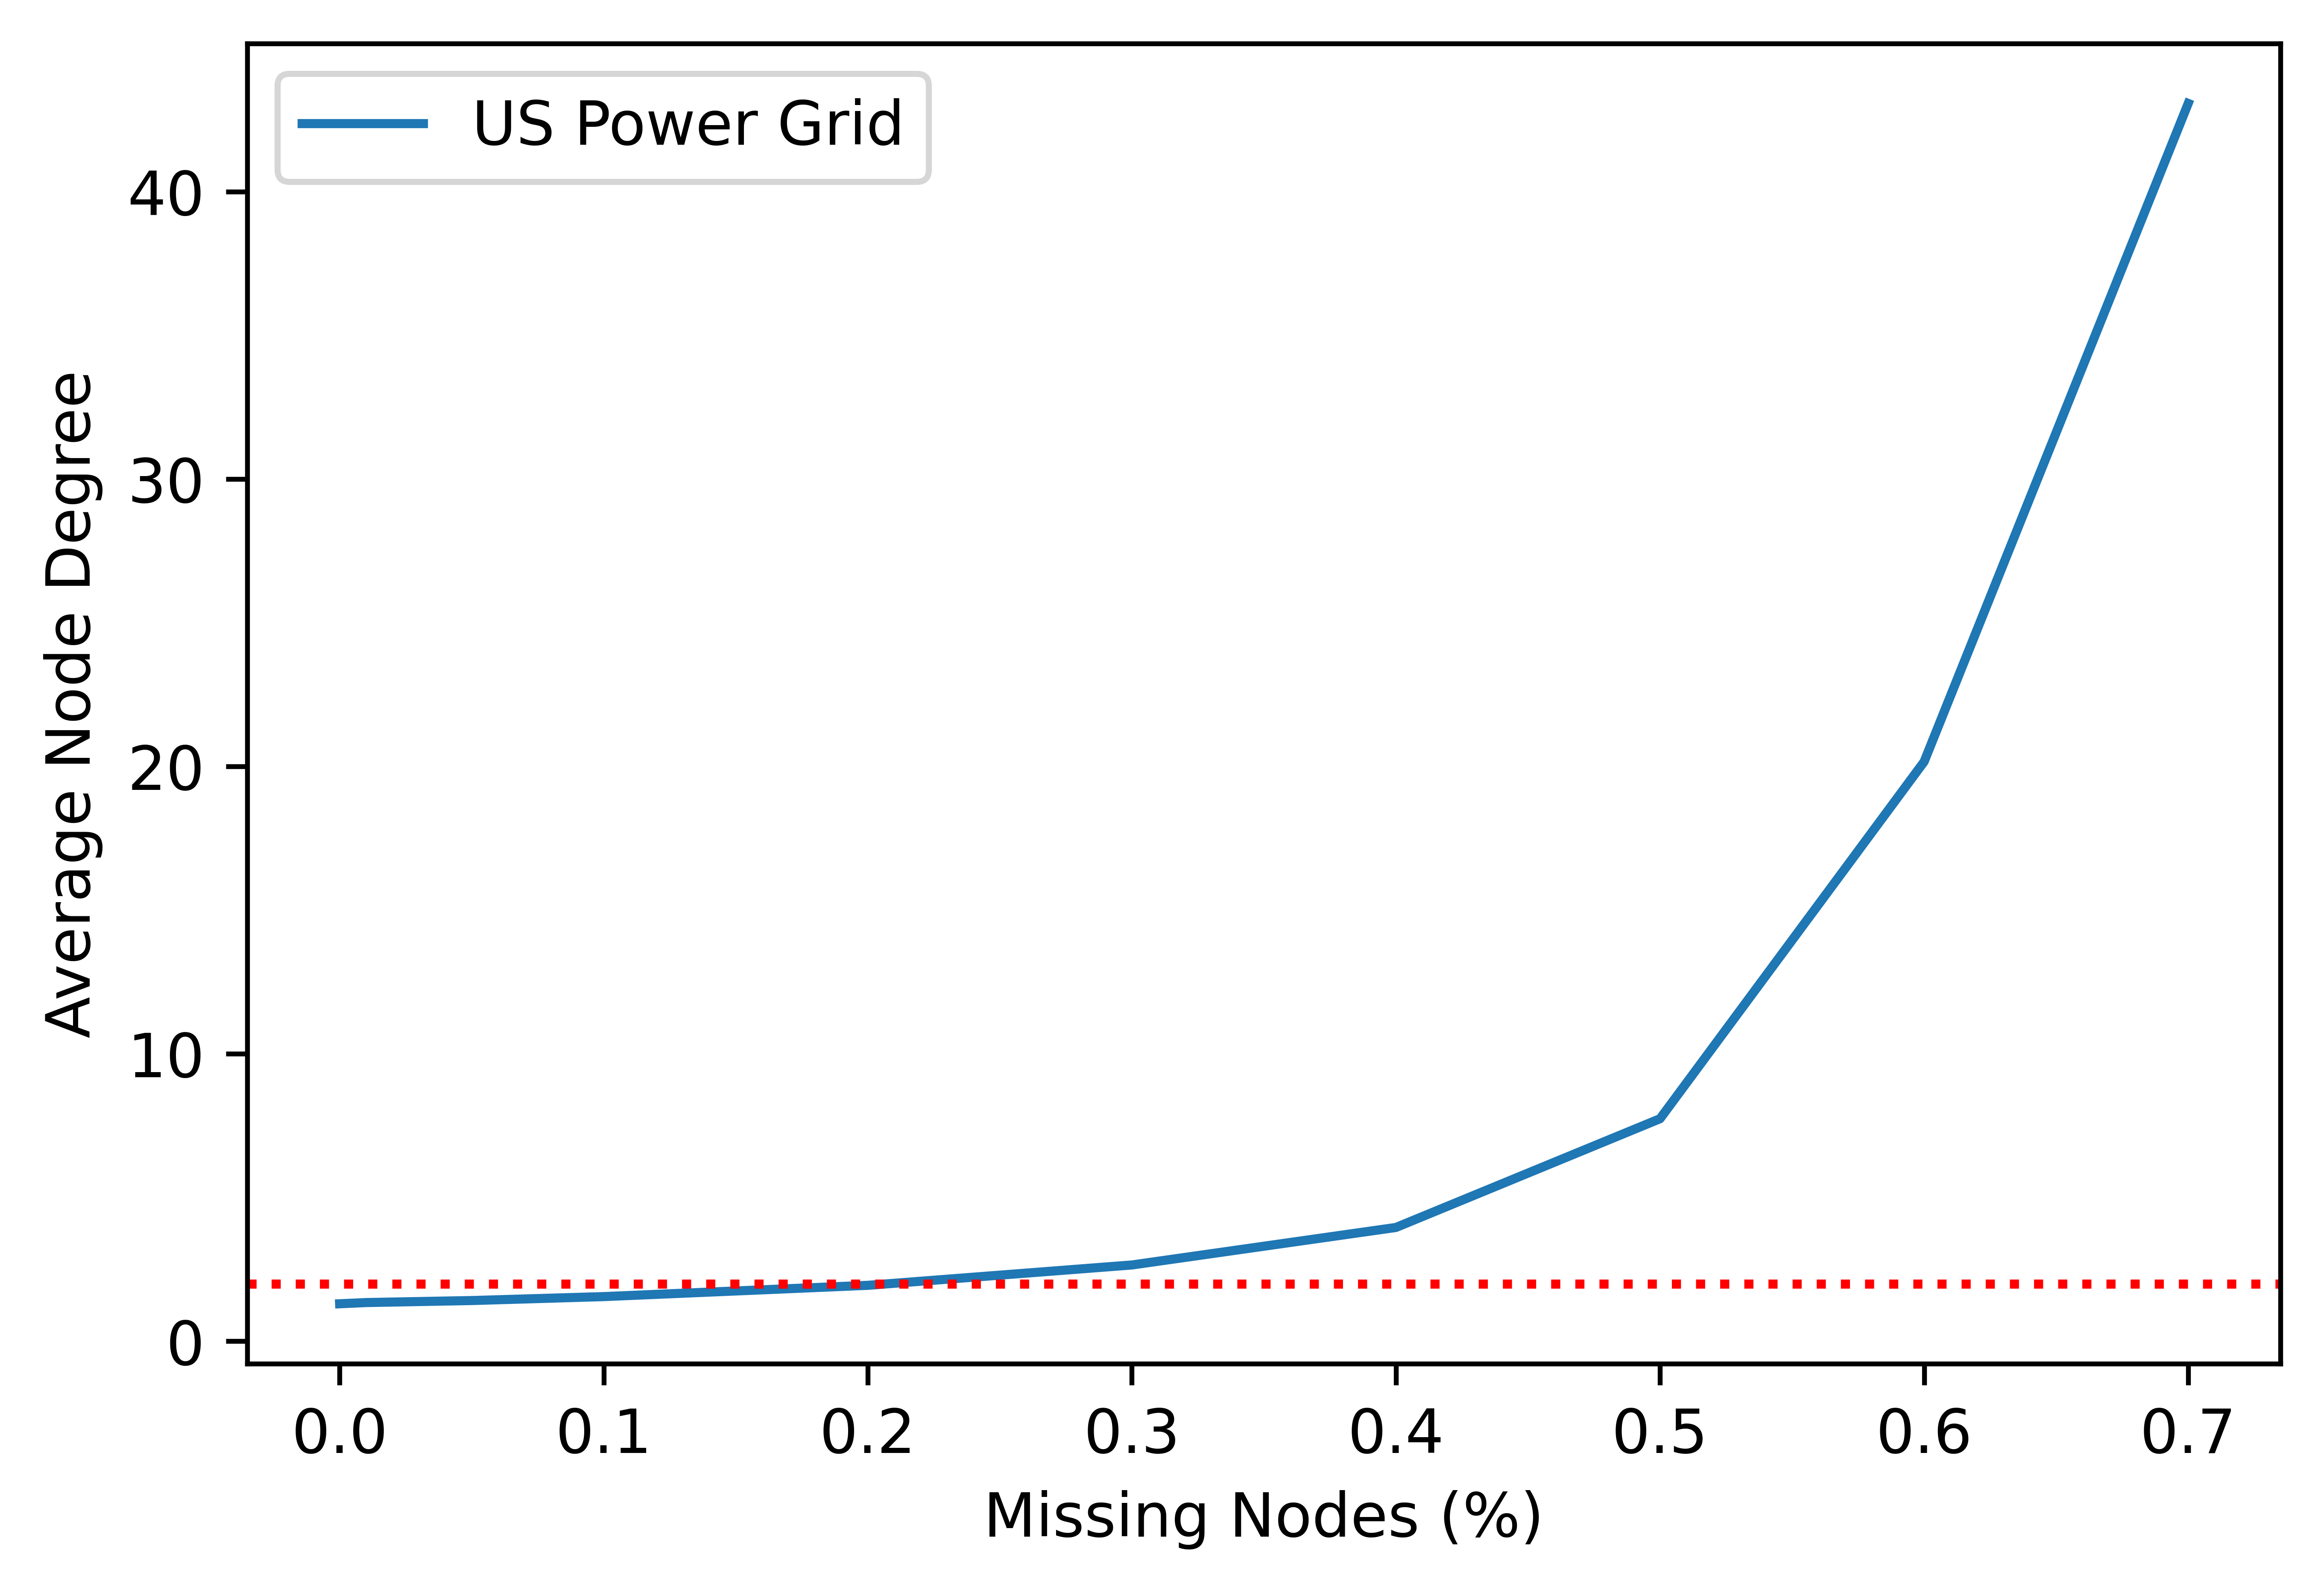

In [103]:
avg_degree_over_percent_missing = {}
for percent_missing, data in r.items():
    degrees = []
    for sample in data:
        if sample is None:
            continue
        ex_g = sample["ex_graph"]
        degrees.append(len(ex_g.edges) / len(ex_g.nodes))
    avg_degree_over_percent_missing[percent_missing] = sum(degrees)/len(degrees)

fig, ax = plt.subplots(1,1)
ax.plot(
    *zip(*sorted(avg_degree_over_percent_missing.items())),
    label="US Power Grid",
)
ax.set_xlabel("Missing Nodes (%)")
ax.set_ylabel("Average Node Degree")
ax.legend()

ax.axline((0.0, 2), (0.7, 2), color="red", linestyle=":")